In [1]:
from datetime import datetime
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from netCDF4 import num2date
import numpy as np
import pandas as pd
import geopandas as gpd
import shapely
from siphon.catalog import TDSCatalog
%matplotlib inline

In [38]:
#def get_wind_forecast_GFS():
best_gfs = TDSCatalog('http://thredds.ucar.edu/thredds/catalog/grib/NCEP/GFS/Global_0p25deg/latest.html')
print(list(best_gfs.datasets))    

best_ds = best_gfs.datasets[0]
ncss = best_ds.subset()

# setup query for waddensea region collecting u- and v-components
query = ncss.query()
query.all_times()
query.lonlat_box(north=53.66, south=52.86, east=7.28, west=4.59)
query.accept('netcdf4')
query.variables('u-component_of_wind_height_above_ground','v-component_of_wind_height_above_ground')
query.vertical_level(10)

data = ncss.get_data(query)
print(list(data.variables))

# get variables in the returend dataset
lat_var = data.variables['lat']
lon_var = data.variables['lon']
u_var = data.variables['u-component_of_wind_height_above_ground']
v_var = data.variables['v-component_of_wind_height_above_ground']
time_name = u_var.coordinates.split()[0]
time_var = data.variables[time_name]

# flat 1 dimension
u_vals = u_var[:].squeeze()
v_vals = v_var[:].squeeze()
lat_vals = lat_var[:].squeeze()
lon_vals = lon_var[:].squeeze()
time_vals = time_var[:].squeeze()

# Convert the number of hours since the reference time to an actual date
time_val = num2date(time_vals, time_var.units)

# # #return lon_vals, lat_vals, u_vals, v_vals, time_val

c:\python35\lib\site-packages\siphon\catalog.py:185: UserWarning: URL http://thredds.ucar.edu/thredds/catalog/grib/NCEP/GFS/Global_0p25deg/latest.html returned HTML. Changing to: http://thredds.ucar.edu/thredds/catalog/grib/NCEP/GFS/Global_0p25deg/latest.xml
  new_url))


['GFS_Global_0p25deg_20180709_1800.grib2']
['v-component_of_wind_height_above_ground', 'time1', 'height_above_ground3', 'lat', 'lon', 'u-component_of_wind_height_above_ground']


In [39]:
time_val

array([datetime.datetime(2018, 7, 9, 18, 0),
       datetime.datetime(2018, 7, 9, 21, 0),
       datetime.datetime(2018, 7, 10, 0, 0),
       datetime.datetime(2018, 7, 10, 3, 0),
       datetime.datetime(2018, 7, 10, 6, 0),
       datetime.datetime(2018, 7, 10, 9, 0),
       datetime.datetime(2018, 7, 10, 12, 0),
       datetime.datetime(2018, 7, 10, 15, 0),
       datetime.datetime(2018, 7, 10, 18, 0),
       datetime.datetime(2018, 7, 10, 21, 0),
       datetime.datetime(2018, 7, 11, 0, 0),
       datetime.datetime(2018, 7, 11, 3, 0),
       datetime.datetime(2018, 7, 11, 6, 0),
       datetime.datetime(2018, 7, 11, 9, 0),
       datetime.datetime(2018, 7, 11, 12, 0),
       datetime.datetime(2018, 7, 11, 15, 0),
       datetime.datetime(2018, 7, 11, 18, 0),
       datetime.datetime(2018, 7, 11, 21, 0),
       datetime.datetime(2018, 7, 12, 0, 0),
       datetime.datetime(2018, 7, 12, 3, 0),
       datetime.datetime(2018, 7, 12, 6, 0),
       datetime.datetime(2018, 7, 12, 9, 0),
  

In [7]:
rd_string = ("+proj=sterea +lat_0=52.15616055555555 +lon_0=5.38763888888889 "
             "+k=0.999908 +x_0=155000 +y_0=463000 +ellps=bessel +units=m " 
             "+towgs84=565.2369,50.0087,465.658,-0.406857330322398,0.350732676542563,-1.8703473836068,4.0812 "
             "+no_defs +no_defs")

In [8]:
# path to shapefile dredgefields
shp_in = r'D:\OmsWaddenzee\trunk\fews\Config\MapLayerFiles\Baggervakken//Baggervakken.shp'

In [9]:
# parse the shapefile into geodataframe
gdf = baggervak_to_current(path_shp=shp_in, crs_string=rd_string)

In [10]:
lon_vals, lat_vals, u_vals, v_vals, time_val = get_wind_forecast_GFS()

In [11]:
df_wind = GFS_to_wind_direction_velocity(lon_vals, lat_vals, u_vals, v_vals, time_val)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000000000A41E128>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x000000000A3D2668>], dtype=object)

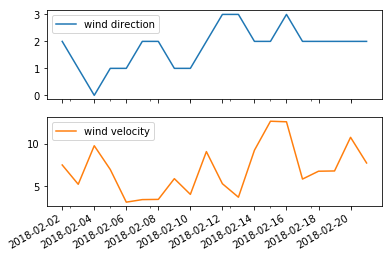

In [12]:
df_wind.plot(subplots=True)

In [31]:
df_wind['wind velocity'].head()

2018-02-02    7.516283
2018-02-03    5.231592
2018-02-04    9.791454
2018-02-05    6.981238
2018-02-06    3.118818
Name: wind velocity, dtype: float64

In [ ]:
df_wind['wind velocity'].to_csv(date_format='%Y%m%d')

In [34]:
df_wind.index[-1].strftime('%Y%m%d')

'20180221'

In [13]:
csv_coeff = r'D:\Projects\Pr\3317.20\Wind_voorspelling\coefficients_baggervakken.csv'
df = pd.io.parsers.read_csv(csv_coeff, header = [0,1], tupleize_cols = True)
df.columns = [c for _, c in df.columns[:1]] + [c for c in df.columns[1:]]
df = df.set_index(df.columns[0])
df.columns = pd.MultiIndex.from_tuples(df.columns, names = ['wind_direction', 'coefficient'])

c:\python35\lib\site-packages\pandas\io\parsers.py:809: FutureWarning: The 'tupleize_cols' argument has been deprecated and will be removed in a future version. Column tuples will then always be converted to MultiIndex.


  self.options, self.engine = self._clean_options(options, engine)


In [14]:
df.head()

wind_direction Unnamed: 1_level_0 coeff_NE      coeff_SE      coeff_SW       \
coefficient            OBJECTNAAM        a    b        a    b        a    b   
OBJECTCODE                                                                    
1.7.2.3.2            Blauwe Slenk     -3.2  9.6      7.4 -5.0     -9.5 -4.0   
1.7.1.3.1         Visjagersgaatje      2.6  2.4      9.5  8.5      1.3  0.2   
1.7.3.1.1          Holwerd - VA25     -5.8  2.7     -3.6 -1.4     -4.3  7.9   
1.7.3.1.2.A             VA4 - VA6     -3.9 -3.1     -4.2  3.1     -1.2 -2.1   
1.7.3.1.3                 Reegeul     -4.8 -8.7     -1.5  2.4      9.5  6.7   

wind_direction coeff_NW       
coefficient           a    b  
OBJECTCODE                    
1.7.2.3.2           4.9  3.9  
1.7.1.3.1          -4.3 -3.3  
1.7.3.1.1          -8.5 -1.0  
1.7.3.1.2.A         1.6 -4.2  
1.7.3.1.3          -9.4  9.9

In [15]:
gdf_merge = pd.merge(gdf,df, right_index=True, left_on='OBJECTCODE')

c:\python35\lib\site-packages\pandas\core\reshape\merge.py:558: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


In [29]:
for idx, item in df_wind.iterrows():
    
    if item['wind direction'] == 0:
        column = 'coeff_NE'
    if item['wind direction'] == 1:
        column = 'coeff_SE'
    if item['wind direction'] == 2:
        column = 'coeff_SW'
    if item['wind direction'] == 3:
        column = 'coeff_NW'
    

    coeff = pd.concat((gdf_merge[['OBJECTCODE', 'OBJECTNAAM', 'geometry']], gdf_merge[(
        column, 'a')], gdf_merge[(column, 'b')]), axis=1)
    coeff.loc[:,'wind_velocity'] = item['wind velocity']
    
    coeff.loc[:,'SDS'] = coeff[(column,'a')]*coeff['wind_velocity']+coeff[(column,'b')]
    print(coeff[['wind_velocity', 'SDS']].head(1))
    print(idx, column, '\n')
    #print(idx, column, item['wind velocity'])

   wind_velocity        SDS
0       7.516283 -75.404692
2018-02-02 coeff_SW 

   wind_velocity        SDS
0       5.231592  33.713782
2018-02-03 coeff_SE 

   wind_velocity        SDS
0       9.791454 -21.732653
2018-02-04 coeff_NE 

   wind_velocity       SDS
0       6.981238  46.66116
2018-02-05 coeff_SE 

   wind_velocity        SDS
0       3.118818  18.079253
2018-02-06 coeff_SE 

   wind_velocity       SDS
0       3.420727 -36.49691
2018-02-07 coeff_SW 

   wind_velocity        SDS
0       3.445152 -36.728941
2018-02-08 coeff_SW 

   wind_velocity        SDS
0       5.896978  38.637636
2018-02-09 coeff_SE 

   wind_velocity        SDS
0       4.038863  24.887589
2018-02-10 coeff_SE 

   wind_velocity        SDS
0       9.096844 -90.420014
2018-02-11 coeff_SW 

   wind_velocity     SDS
0       5.298163  29.861
2018-02-12 coeff_NW 

   wind_velocity       SDS
0        3.70332  22.04627
2018-02-13 coeff_NW 

   wind_velocity        SDS
0       9.257308 -91.944422
2018-02-14 coeff_SW 

In [22]:
coeff

,OBJECTCODE,OBJECTNAAM,geometry,"(coeff_SW, a)","(coeff_SW, b)",wind_velocity,SDS
0,1.7.2.3.2,Blauwe Slenk,"POLYGON ((149442.7124357932 580249.0740603911,...",-9.5,-4.0,7.750879,-77.633354
1,1.7.1.3.1,Visjagersgaatje,"POLYGON ((129625.932283378 552658.7841377998, ...",1.3,0.2,7.750879,10.276143
2,1.7.3.1.1,Holwerd - VA25,"POLYGON ((185317.6546756364 601556.7232466646,...",-4.3,7.9,7.750879,-25.428781
3,1.7.3.1.2.A,VA4 - VA6,"POLYGON ((181240.1501464844 604087.0973510742,...",-1.2,-2.1,7.750879,-11.401055
4,1.7.3.1.3,Reegeul,"POLYGON ((180660.1662909701 605207.5438269211,...",9.5,6.7,7.750879,80.333354
5,1.7.4.1.2,Groote Siege,"POLYGON ((208368.5672481135 608845.8988347277,...",6.1,3.6,7.750879,50.880364
6,1.7.2.1.1,Slenk,"POLYGON ((146331.7969360426 592505.9215698245,...",-5.4,4.7,7.750879,-37.154749
8,1.7.2.3.3,Pannengat,"POLYGON ((139842.4711156413 585776.9337197393,...",5.6,-8.8,7.750879,34.604924
9,1.7.3.2.1.2,"Ballumerbocht, Vaargeul","POLYGON ((177645.1331116892 605234.8622330613,...",-5.3,-10.0,7.750879,-51.079661
10,1.7.1.5.1.K,"Boontjes, Vak 11","POLYGON ((154211.8018188476 571254.9010009796,...",-1.5,-8.6,7.750879,-20.226319
